# **Design Space Exploration**
- Define the most suitable hardware architecture to implement StereoSpike network.
    - Leverage the use of Depthwise Separable (DWS) convolutions.
- The metrics chosen to explore the architectures are memory traffic and latency.

## *Libraries:*

In [125]:
import os

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
import matplotlib.font_manager as fm
from matplotlib import rcParams
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np

import math
from dataclasses import dataclass
from typing import List, Tuple, Any, Optional
from pprint import pprint

import seaborn as sns
import pandas as pd

## *Functions:*

In [2]:
# Decorator to simplify the creation of data classes that are intented to store data
@dataclass
class ConvLayerSpec:
    name: str  # Optional: to identify layer (e.g., "conv3_1_dw")
    input_shape: Tuple[int, int, int]  # (C, H, W)
    output_shape: Tuple[int, int, int]  # (M, P, Q)

In [3]:
# Set global palette
p_blue = '#0077ed'
p_red = '#db2134'
p_green = '#11a329'
p_orange = '#e89000'

In [68]:
def original_mem_traffic(
    filter_size: Tuple[int, int],
    output_shape: Tuple[int, int, int],
    input_shape: Tuple[int, int, int],
    n_bit: Tuple[int, int, int]

) -> float:
    """
    Compute the off/on-chip memory traffic for all the original architectures.
        - Per-layer computation.
        - Assumes ideal data reuse --> read or write only once per same data
    
    Parameters:
    ----------
    filter_size : Tuple[int, int]
        The size of the depthwise filter (R, S).
    output_shape : Tuple[int, int, int]
        The shape of the output feature map (M, P, Q).
        M - number of output channels,
        P - height,
        Q - width.
    input_shape : Tuple[int, int, int]
        The shape of the input feature map (C, H, W).
        C - number of input channels,
        H - height,
        W - width.
    n_bit : Tuple[int, int, int]
        Number of bits for (weights, pfmap, ofmap).

    Returns:
    -------
    float
        Estimated off/on-chip memory traffic on Mb (Mega bits).
    """
    ## Unpack parameters
    R, S = filter_size
    M, P, Q = output_shape
    C, H, W = input_shape
    n_w, n_pfm, n_ofm = n_bit

    ## Compute the number of elements per tensor
    # 1.- ifmap (DW)
    a_1 = C * H * W
    # 2.- ofmap (PW)
    a_2 = M * P * Q
    # 3.- pfmap (DW --> PW)
    a_3 = C * P * Q
    # 4.- weights (DW and PW)
    a_4 = (C * R * S) + (M * C)

    ## Compute on-chip Memory Traffic: [read] + [write]
    # Here, we assume that ofmap (2) are multibit data to consider all possible accumulations before activation function during read
    # but during write we consider only the final value after activation function so we use binary data
    # - (1) and (2) are binary data
    # - (2), (3), and (4) are multibit data
    # Moreover, all architectures have the same traffic for on-chip memory
    on_chip_traffic = ((a_1) + (a_2) + (a_3*n_pfm) + (a_4*n_w)) + ((a_2*n_ofm) + (a_3*n_pfm))

    ## Compute off-chip Memory Traffic: [read] + [write]
    # Here, we assume that ofmap (2) are binary data to consider the final value after activation function
    # - This is not valid for prediction layers since we need the final depth map
    # Moreover, SE and RE share the same off-chip memory traffic

    # Condition for prediction layers: only 1 output channel
    if M != 1:
        n_ofm = 1  # binary data
    
    # For UE: (3) and (4) are multibit data
    off_chip_traffic_ue = ((a_1) + (a_3*n_pfm) + (a_4*n_w)) + ((a_2*n_ofm) + (a_3*n_pfm))
    
    # For SE and RE: (4) is multibit data
    off_chip_traffic = ((a_1) + (a_4*n_w)) + (a_2*n_ofm) 

    return [off_chip_traffic_ue/2**20, off_chip_traffic/2**20, on_chip_traffic/2**20]  # in Mb

In [5]:
def analyze_original_mem_traffic(
    network_layers: List[ConvLayerSpec],
    filter_size: Tuple[int, int],
    n_bit: Tuple[int, int, int]

) -> float:
    """
    Compute and organize the off/on-chip memory traffic for all the conventional architectures.
        - Per-layer computation.
        - Assumes ideal data reuse --> read or write only once per same data.
        - Provide data visualization.
    
    Parameters:
    ----------
    network_layers: List[ConvLayerSpec]
        List of convolutional layer specifications in the network.
    filter_size : Tuple[int, int]
        The size of the depthwise filter (R, S).
    n_bit : Tuple[int, int, int]
        Number of bits for (weights, pfmap, ofmap).

    Returns:
    -------
    float
        Estimated off/on-chip memory traffic on Mb (Mega bits).
    """

    # Store results
    traffic_results = []

    for layer in network_layers: 
        off_ue, off_other, on_all = original_mem_traffic(
            filter_size=filter_size,
            output_shape=layer.output_shape,
            input_shape=layer.input_shape,
            n_bit=n_bit
        )

        traffic_results.append({
            "layer": layer.name,
            "UE_off": off_ue,
            "SE_off": off_other,
            "RE_off": off_other,
            "UE_on": on_all,
            "SE_on": on_all,
            "RE_on": on_all
        })

    ## Data visualization for analysis
    # Plot settings
    p_dpi = 100
    fig_w_in = 6
    fig_h_in = 10
    palette = {"UE": p_blue, "SE": p_orange, "RE": p_green}
    fig, axes = plt.subplots(3, 1, figsize=(fig_w_in, fig_h_in), dpi=p_dpi, sharex=True)
    ax0, ax1, ax2 = axes[0], axes[1], axes[2]

    # Step 1: Collect traffic for each architecture
    
    # off-chip memory traffic
    ue_off_traffic = [entry["UE_off"] for entry in traffic_results]
    se_off_traffic = [entry["SE_off"] for entry in traffic_results]
    re_off_traffic = [entry["RE_off"] for entry in traffic_results]

    # on-chip memory traffic
    ue_on_traffic = [entry["UE_on"] for entry in traffic_results]
    se_on_traffic = [entry["SE_on"] for entry in traffic_results]
    re_on_traffic = [entry["RE_on"] for entry in traffic_results]

    # Step 2: Build a long-form DataFrame for seaborn
    df = pd.DataFrame({
        "off_traffic": ue_off_traffic + se_off_traffic + re_off_traffic,
        "Architecture": (["UE"] * len(ue_off_traffic)
                        + ["SE"] * len(se_off_traffic)
                        + ["RE"] * len(re_off_traffic))
    })
    # display(df)

    df1 = pd.DataFrame({
    "on_traffic": ue_on_traffic + se_on_traffic + re_on_traffic,
    "Architecture": (["UE"] * len(ue_on_traffic)
                     + ["SE"] * len(se_on_traffic)
                     + ["RE"] * len(re_on_traffic))
    })
    # display(df1)
    


    # Step 3: Plot boxplot + jittered points
    sns.boxplot(x="Architecture", y="off_traffic", data=df, ax=ax0, 
                palette=palette, hue="Architecture", showfliers=False)
    # sns.stripplot(x="Architecture", y="Latency", data=df,
    #               color=".3", jitter=False, size=5, alpha=0.7)

    # Labeling
    ax0.set_xlabel('')
    ax0.set_ylabel("off-chip Traffic (Mb)")
    ax0.set_title("Memory Traffic Distribution: off-chip")
    ax0.grid(True, linestyle='--', alpha=0.4)

    # Zoom-in off-chip traffic for SE and RE architectures
    sns.boxplot(x="Architecture", y="off_traffic", data=df, ax=ax1, 
                palette=palette, hue="Architecture", showfliers=False)
    ax1.set_ylim(1, max(se_off_traffic)*1.1)
    # Labeling
    ax1.set_xlabel('')
    ax1.set_ylabel("off-chip Traffic (Mb)")
    ax1.set_title("Memory Traffic Distribution: off-chip (zoom-in)")
    ax1.grid(True, linestyle='--', alpha=0.4)
    
    sns.boxplot(x="Architecture", y="on_traffic", data=df1, ax=ax2, 
                palette=palette, hue="Architecture", showfliers=False)
    # sns.stripplot(x="Architecture", y="Latency", data=df,
    #               color=".3", jitter=False, size=5, alpha=0.7)

    # Labeling
    ax2.set_xlabel('')
    ax2.set_ylabel("on-chip Traffic (Mb)")
    ax2.set_title("Memory Traffic Distribution: on-chip")
    ax2.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.show()

    return traffic_results

In [6]:
def ue_latency_estimate(
    filter_size: Tuple[int, int],
    output_shape: Tuple[int, int, int],
    input_channels: int,
    compute_array_shape: Tuple[int, int]
) -> int:
    """
    Compute the latency to process a Depthwise Separable Convolution layer on a unified engine architecture.

    Parameters:
    ----------
    filter_size : Tuple[int, int]
        The size of the depthwise filter (R, S).
    output_shape : Tuple[int, int, int]
        The shape of the output feature map (M, P, Q).
        M - number of output channels,
        P - height,
        Q - width.
    input_channels : int
        Number of input channels (C).
    compute_array_shape : Tuple[int, int]
        The shape of the compute array (i_UE, j_UE).

    Returns:
    -------
    int
        Estimated latency (in clock cycles) to compute the layer.
    """

    # Unpack inputs
    R, S = filter_size
    M, P, Q = output_shape
    C = input_channels
    i_UE, j_UE = compute_array_shape

    # Input validation
    if i_UE <= 0 or j_UE <= 0:
        raise ValueError("Compute array dimensions must be positive integers.")
    if R <= 0 or S <= 0 or M <= 0 or P <= 0 or Q <= 0 or C <= 0:
        raise ValueError("Filter and feature map dimensions must be positive integers.")

    # Calculate latency terms
    # First term: depthwise convolution
    term1_rows = math.ceil((R * S) / i_UE)
    term1_cols = math.ceil(C / j_UE)
    latency_dw = term1_rows * P * Q * term1_cols

    # Second term: pointwise convolution (1x1 conv)
    term2_rows = math.ceil(C / i_UE)
    term2_cols = math.ceil(M / j_UE)
    latency_pw = term2_rows * P * Q * term2_cols

    # Total latency
    total_latency = latency_dw + latency_pw

    return total_latency

In [7]:
def se_latency_estimate(
    output_shape: Tuple[int, int, int],
    input_channels: int,
    compute_array_shape_pw: Tuple[int, int]
) -> int:
    """
    Estimate latency of a Depthwise Separable Convolution layer on a Separate Engine (SE) architecture.

    This function models the pointwise convolution latency only,
    assuming depthwise latency is masked by the pointwise.

    Parameters:
    ----------
    output_shape : Tuple[int, int, int]
        The shape of the output feature map (M, P, Q):
        M - number of output channels,
        P - height,
        Q - width.
    input_channels : int
        Number of input channels (C).
    compute_array_shape_pw : Tuple[int, int]
        The compute array shape for pointwise convolution (i_SE^P, j_SE^P).

    Returns:
    -------
    int
        Estimated latency (in clock cycles) for pointwise conv on SE architecture.
    """

    # Unpack values
    M, P, Q = output_shape
    C = input_channels
    i_SE_p, j_SE_p = compute_array_shape_pw

    # Input validation
    if i_SE_p <= 0 or j_SE_p <= 0:
        raise ValueError("Compute array dimensions must be positive integers.")
    if M <= 0 or P <= 0 or Q <= 0 or C <= 0:
        raise ValueError("Feature map dimensions must be positive integers.")

    # Compute latency
    row_tiles = math.ceil(C / i_SE_p)
    col_tiles = math.ceil(M / j_SE_p)
    latency_pw = row_tiles * P * Q * col_tiles

    return latency_pw

In [8]:
def re_latency_estimate(
    filter_size: Tuple[int, int],
    output_shape: Tuple[int, int, int],
    input_channels: int,
    compute_array_shape: Tuple[int, int],
    dw_c_inter: int,
    dw_c_intra: int,
    verbose: bool = False
) -> int:
    """
    Estimate latency for a Depthwise Separable Convolution layer on a Reconfigurable Engine (RE) architecture.

    Parameters:
    ----------
    filter_size : Tuple[int, int]
        Size of the depthwise filter (R, S).
    output_shape : Tuple[int, int, int]
        Output shape as (M, P, Q):
        M - number of output channels,
        P - output height,
        Q - output width.
    input_channels : int
        Number of input channels (C).
    compute_array_shape : Tuple[int, int]
        The RE compute array dimensions (i_RE, j_RE).
    dw_c_inter/intra : int
        Number of columns in the compute array dedicated to depthwise (DW) convolution (d).
            - It depends on the operation mode to optmize the reconfigurable array.
    verbose : bool, optional
        If True, prints detailed computation steps (default is False).

    Returns:
    -------
    int
        Estimated latency (clock cycles).
    """

    # Unpack inputs
    R, S = filter_size
    M, P, Q = output_shape
    C = input_channels
    i_RE, j_RE = compute_array_shape

    # Validate inputs
    if any(x <= 0 for x in [R, S, M, P, Q, C, i_RE, j_RE, dw_c_inter, dw_c_intra]):
        raise ValueError("All parameters must be positive integers.")
    if dw_c_inter >= j_RE or dw_c_intra >= j_RE :
        raise ValueError("Number of DW columns (d) must be less than total compute columns (j_RE).")

    # --- Operation mode decision ---
    left_expr = Q * C + C * M
    right_expr = P * Q * C + C * j_RE

    operation_mode = "inter-channel" if left_expr <= right_expr else "intra-channel"

    if verbose:
        print(f"Operation mode: {operation_mode}")

    # --- Inter-channel latency ---
    if operation_mode == "inter-channel":
        # Assign d based on inter-channel mode
        d = dw_c_inter

        if M <= (j_RE - d):
            latency = P * Q * R * math.ceil(C / d)
            if verbose:
                print('pipeline: DW-PW')
        else:
            latency = math.ceil(C / i_RE) * P * Q * math.ceil(M / (j_RE - d))
            if verbose:
                print('pipeline: PW-DW')

    # --- Intra-channel latency ---
    else:
        # Assign d based on intra-channel mode
        d = dw_c_intra

        ceil_C_over_d = math.ceil(C / d)
        ceil_C_over_j_d = math.ceil(C / (j_RE - d))
        floor_inner = math.floor(R*ceil_C_over_d / ceil_C_over_j_d)
        term2_numerator = M - floor_inner
        term2_numerator = max(0, term2_numerator)  # Avoid negative tiles

        latency_stage1 = P * Q * R * ceil_C_over_d
        latency_stage2 = P * Q * math.ceil(C / i_RE) * math.ceil(term2_numerator / j_RE)

        latency = latency_stage1 + latency_stage2

    return latency

In [74]:
def analyze_original_latency(
    network_layers: List[ConvLayerSpec],    
    filter_size: Tuple[int, int],
    compute_array_ue: Tuple[int, int],
    compute_array_se: Tuple[int, int],
    compute_array_re: Tuple[int, int],
    dw_c_inter: int,
    dw_c_inter_pred: int,
    dw_c_intra: int,
    verbose: bool = False
) -> int:
    """
    Analyze and estimate the latency for all layers in the network across different architectures:
    Unified Engine (UE), Separate Engine (SE), and Reconfigurable Engine (RE).
    - Data visualization.

    Parameters:
    ----------
    network_layers: List[ConvLayerSpec]
        List of convolutional layer specifications in the network.
    filter_size : Tuple[int, int]
        The size of the depthwise filter (R, S).
    compute_array_ue : Tuple[int, int]
        Compute array shape for UE architecture (i_UE, j_UE).
    compute_array_se : Tuple[int, int]
        Compute array shape for SE architecture (i_SE^P, j_SE^P).
    compute_array_re : Tuple[int, int]
        Compute array shape for RE architecture (i_RE, j_RE).
    dw_c_inter : int
        Number of columns for DW in RE for inter-channel operation.
    dw_c_inter_pred : int
        Number of columns for DW in RE for inter-channel operation in prediction layers.
    dw_c_intra : int
        Number of columns for DW in RE for intra-channel operation.
    verbose : bool, optional
        If True, prints detailed computation steps (default is False).

    Returns:
    -------
    int
        Total estimated latency across all layers for each architecture.
    """

    # Store results
    latency_results = [] 

    for layer in network_layers:
        ue_latency = ue_latency_estimate(
            filter_size=filter_size,
            output_shape=layer.output_shape,
            input_channels=layer.input_shape[0],
            compute_array_shape=compute_array_ue
        )
        
        se_latency = se_latency_estimate(
            output_shape=layer.output_shape,
            input_channels=layer.input_shape[0],
            compute_array_shape_pw=compute_array_se
        )

        if verbose:
            print(f'\nFor RE Architecture, layer {layer.name}')

        # For Prediction layers, there is only 1 output channel, so we leave only the last column
        # for PW convolution and the rest for DW convolution --> inter-channel operation
        if layer.name.startswith("depth"):
            dw_cols_inter = dw_c_inter_pred
        else:
            dw_cols_inter = dw_c_inter  # Reset to default for other layers

        re_latency = re_latency_estimate(
            filter_size=filter_size,
            output_shape=layer.output_shape,
            input_channels=layer.input_shape[0],
            compute_array_shape=compute_array_re,
            dw_c_inter=dw_cols_inter,
            dw_c_intra=dw_c_intra,
            verbose=verbose  # Set to True for detailed output
        )


        latency_results.append({
            "layer": layer.name,
            "UE_latency": ue_latency,
            "SE_latency": se_latency,
            "RE_latency": re_latency
        })   
    
    ## Data visualization for analysis
    # Plot settings
    p_dpi = 100
    fig_w_in = 12
    fig_h_in = 7
    palette = {"UE": p_blue, "SE": p_orange, "RE": p_green}
    # fig, axes = plt.subplots(3, 1, figsize=(fig_w_in, fig_h_in), dpi=p_dpi, sharex=True)
    # ax0, ax1, ax2 = axes[0], axes[1], axes[2]
    fig, axes = plt.subplots(1, 2, figsize=(fig_w_in, fig_h_in), dpi=p_dpi, gridspec_kw={'width_ratios': [2, 1]})
    ax0, ax1 = axes[0], axes[1]

    # Step 1: Collect latency values for each architecture
    # Rescale to Millon Cycles (10^6)
    layers = [entry["layer"] for entry in latency_results]
    ue_latencies = [entry["UE_latency"] / 1_000_000 for entry in latency_results] 
    se_latencies = [entry["SE_latency"] / 1_000_000 for entry in latency_results] 
    re_latencies = [entry["RE_latency"] / 1_000_000 for entry in latency_results] 

    # Step 2: Build a long-form DataFrame for seaborn
    df = pd.DataFrame({
        "Latency": ue_latencies + se_latencies + re_latencies,
        "Architecture": (["UE"] * len(ue_latencies)
                        + ["SE"] * len(se_latencies)
                        + ["RE"] * len(re_latencies))
    })
    # display(df)

    # Step 3: Plot boxplot + jittered points
    sns.boxplot(x="Architecture", y="Latency", data=df, 
                ax=ax1, palette=palette, hue="Architecture", showfliers=False)
    # sns.stripplot(x="Architecture", y="Latency", data=df,
    #               color=".3", jitter=False, size=5, alpha=0.7)

    # Set the ticks every 0.1 since seaborn autoscale may not set them properly
    ax1.yaxis.set_major_locator(MultipleLocator(0.05))
    # set the minimum limit to 0
    ax1.set_ylim(bottom=0)
    
    # Labeling
    ax1.set_xlabel("")
    ax1.set_ylabel(r'Latency ($\times 10^{6}$ cycles)')
    ax1.set_title("Latency Distribution per Architecture")
    ax1.grid(True, linestyle='--', alpha=0.4)

    # Step 4: Plot latency per layer
    x_bar = np.arange(len(layers))  # positions for groups
    bar_width = 0.25

    ax0.bar(x_bar - bar_width, ue_latencies, width=bar_width, label='UE', color=p_blue)
    ax0.bar(x_bar, se_latencies, width=bar_width, label='SE', color=p_orange)
    ax0.bar(x_bar + bar_width, re_latencies, width=bar_width, label='RE', color=p_green)    

    # Labeling
    ax0.set_xlabel("")
    ax0.set_ylabel(r'Latency ($\times 10^{6}$ cycles)')
    ax0.set_title("Latency per Layer")
    ax0.set_xticks(ticks=x_bar, labels=layers, rotation=45, ha='right')
    ax0.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.show()

    return latency_results

In [78]:
def prop_mem_traffic(
    filter_size: Tuple[int, int],
    output_shape: Tuple[int, int, int],
    input_shape: Tuple[int, int, int],
    n_bit: Tuple[int, int, int]

) -> float:
    """
    Compute the off/on-chip memory traffic for all the proposed SE architecture.
        - Per-layer computation.
        - Follows the assumption of ideal reuse, but considers the partial ofmaps accumulations.
            - 1 multibit read and 1 binary write for ofmaps.
    
    Parameters:
    ----------
    filter_size : Tuple[int, int]
        The size of the depthwise filter (R, S).
    output_shape : Tuple[int, int, int]
        The shape of the output feature map (M, P, Q).
        M - number of output channels,
        P - height,
        Q - width.
    input_shape : Tuple[int, int, int]
        The shape of the input feature map (C, H, W).
        C - number of input channels,
        H - height,
        W - width.
    n_bit : Tuple[int, int, int]
        Number of bits for (weights, pfmap, ofmap).

    Returns:
    -------
    float
        1. Estimated off/on-chip memory traffic on Mb (Mega bits).
        2. Estimated contribution of each tensor to the each traffic on Mb.
    """

    ## Unpack parameters
    R, S = filter_size
    M, P, Q = output_shape
    C, H, W = input_shape
    n_w, n_pfm, n_ofm = n_bit

    ## Compute the number of elements per tensor
    # 1.- Event frames: only in the stem layer
    if C == 4:
        a_1 = C * H * W 
    else:
        a_1 = 0
    # 2.- ifmap (DW)
    a_2 = C * H * W
    # 3.- ofmap (PW)
    a_3 = M * P * Q
    # 4.- pfmap (DW --> PW) no intermediate data in our proposed architecture
    a_4 = 0
    # 5.- weights (DW and PW)
    a_5 = (C * R * S) + (M * C)
    # 6.- Depth map: only in the prediction layers (assume an off-chip accumulation)
    if M == 1:
        a_6 = P * Q
    else:
        a_6 = 0

    ## off-chip Traffic:
    # Individual memory traffic
    # 1.- Event frames: binary data
    off_1 = a_1
    # 5.- weights: multibit data
    off_5 = a_5 * n_w
    # 6.- depth map: multibit data
    off_6 = a_6 * n_ofm

    # Total off-chip memory traffic
    off_chip_traffic = off_1 + off_5 + off_6

    ## on-chip Traffic:
    # Individual memory traffic
    # 2.- ifmap (DW): binary data
    on_2 = a_2
    # 5.- weights (DW and PW): multibit data
    on_5 = a_5 * n_w
    # 3.- ofmap (PW):
    #   - stem and conv1: only 1 write (binary data)
    #   - prediction layers: 1 read (multibit data) + 1 write (multibit data)
    #   - other layers: 1 read (multibit data) + 1 write (binary data)
    if C == 4 or C == 32:
        on_3 = a_3 
    elif M == 1:
        on_3 = 2*(a_3 * n_ofm)
    else:
        on_3 = (a_3 * n_ofm) + a_3
    
    # Total on-chip memory traffic
    on_chip_traffic = on_2 + on_5 + on_3

    return [off_chip_traffic/2**20, off_1/2**20, off_5/2**20, off_6/2**20], [on_chip_traffic/2**20, on_2/2**20, on_5/2**20, on_3/2**20]  # in Mb

In [95]:
def analyze_prop_mem_traffic(
    network_layers: List[ConvLayerSpec],
    filter_size: Tuple[int, int],
    n_bit: Tuple[int, int, int]

) -> float:
    """
    Compute and organize the off/on-chip memory traffic for the proposed SE aechitecture.
        - Per-layer computation.
        - Assumes ideal data reuse --> read or write only once per same data.
        - Provide data visualization.
    
    Parameters:
    ----------
    network_layers: List[ConvLayerSpec]
        List of convolutional layer specifications in the network.
    filter_size : Tuple[int, int]
        The size of the depthwise filter (R, S).
    n_bit : Tuple[int, int, int]
        Number of bits for (weights, pfmap, ofmap).

    Returns:
    -------
    float
        Estimated off/on-chip memory traffic on Mb (Mega bits).
    """

    # Store results
    prop_traffic_results = []

    for layer in network_layers:
        
        off_info, on_info = prop_mem_traffic(
            filter_size=filter_size,
            output_shape=layer.output_shape,
            input_shape=layer.input_shape,
            n_bit=n_bit
        )

        prop_traffic_results.append({
            "layer": layer.name,
            "off_total": off_info[0],
            "off_1": off_info[1],
            "off_5": off_info[2],
            "off_6": off_info[3],
            "on_total": on_info[0],
            "on_2": on_info[1],
            "on_5": on_info[2],
            "on_3": on_info[3]
        })
    
    ## Data visualization for analysis
    # Plot settings
    p_dpi = 100
    fig_w_in = 10
    fig_h_in = 6
    palette = {"off-chip": p_blue, "on-chip": p_orange}
    # fig, axes = plt.subplots(3, 1, figsize=(fig_w_in, fig_h_in), dpi=p_dpi, sharex=True)
    # ax0, ax1, ax2 = axes[0], axes[1], axes[2]
    fig, axes = plt.subplots(1, 2, figsize=(fig_w_in, fig_h_in), dpi=p_dpi, gridspec_kw={'width_ratios': [1, 1]})
    ax0, ax1 = axes[0], axes[1]

    # Step 1: Collect latency values for each architecture
    off_traffic = [entry["off_total"] for entry in prop_traffic_results]
    on_traffic = [entry["on_total"] for entry in prop_traffic_results]

    # Step 2: Build a long-form DataFrame for seaborn
    df1 = pd.DataFrame({
        "off_traffic": off_traffic,
        "Architecture": (["off-chip"] * len(off_traffic))
    })
    df = pd.DataFrame({
        "on_traffic": on_traffic,
        "Architecture": (["on-chip"] * len(on_traffic))
    })
    # display(df)

    # Step 3: Plot boxplot + jittered points
    sns.boxplot(x="Architecture", y="off_traffic", data=df1, 
                ax=ax0, palette=palette, hue="Architecture", showfliers=False)
    # sns.stripplot(x="Architecture", y="Latency", data=df,
    #               color=".3", jitter=False, size=5, alpha=0.7)

    # Set the ticks every 0.1 since seaborn autoscale may not set them properly
    # ax0.yaxis.set_major_locator(MultipleLocator(0.05))
    # set the minimum limit to 0
    ax0.set_ylim(bottom=0)
    
    # Labeling
    ax0.set_xlabel("")
    ax0.set_ylabel('Memory Traffic (Mb)')
    ax0.grid(True, linestyle='--', alpha=0.4)

    sns.boxplot(x="Architecture", y="on_traffic", data=df, 
                ax=ax1, palette=palette, hue="Architecture", showfliers=False)
    # sns.stripplot(x="Architecture", y="Latency", data=df,
    #               color=".3", jitter=False, size=5, alpha=0.7)

    # Set the ticks every 0.1 since seaborn autoscale may not set them properly
    # ax0.yaxis.set_major_locator(MultipleLocator(0.05))
    # set the minimum limit to 0
    ax1.set_ylim(bottom=0)
    
    # Labeling
    ax1.set_xlabel("")
    ax1.set_ylabel('Memory Traffic (Mb)')
    ax1.grid(True, linestyle='--', alpha=0.4)

    # General Title
    fig.suptitle("Memory Traffic Distribution for proposed SE Architecture")

    plt.tight_layout()
    plt.show()

    return prop_traffic_results

In [203]:
def plot_total_se_latency_surface(
    network_layers: List[ConvLayerSpec],
    se_array_pw_range_i: Tuple[int,int] = (32, 512),
    se_array_pw_range_j: Tuple[int,int] = (64, 512),
    step_i: int = 32,
    step_j: int = 32,
    primary_ylim: Optional[float] = None,
    cmap: str = "viridis",
    figsize_cm: Tuple[float,float] = (25, 25),
    dpi: int = 100,
    show: bool = True
):
    """
    Compute total SE latency (sum of per-layer pointwise latencies) over a grid of
    compute-array shapes (i, j) and plot a 3D surface.

    - network_layers: list of layer descriptors (object/dict/tuple)
    - se_array_pw_range_i: inclusive (min_i, max_i)
    - se_array_pw_range_j: inclusive (min_j, max_j)
    - step_i/step_j: sampling step (use 1 for dense grid; default 32)
    - primary_ylim: not used for surface; left for compatibility if embedding
    - figsize_cm: (width_cm, height_cm)
    - returns (fig, ax, latency_grid, i_vals, j_vals)
    """
    # build i and j arrays (ensure we include upper bound)
    i_min, i_max = se_array_pw_range_i
    j_min, j_max = se_array_pw_range_j
    if step_i <= 0 or step_j <= 0:
        raise ValueError("step_i and step_j must be positive integers")

    i_vals = np.arange(i_min, i_max + 1, step_i, dtype=np.int64)
    j_vals = np.arange(j_min, j_max + 1, step_j, dtype=np.int64)

    # meshgrid (X axis = i, Y axis = j)
    I, J = np.meshgrid(i_vals, j_vals, indexing="xy")  # shapes (len(j_vals), len(i_vals))

    # initialize latency grid (float for safety)
    latency_grid = np.zeros_like(I, dtype=np.float64)

    # accumulate per-layer latency (vectorized)
    bottleneck_name = "bottleneck"
    bottleneck_latency_grid = None
    for layer in network_layers:
        name = layer.name
        out_shape = layer.output_shape
        in_shape = layer.input_shape
        # input_channels C is in_shape[0], output_shape is out_shape (M,P,Q)
        C = int(in_shape[0])
        M = int(out_shape[0])
        P = int(out_shape[1])
        Q = int(out_shape[2])

        # compute row_tiles and col_tiles as arrays over grid
        row_tiles = np.ceil(C / I).astype(np.int64)    # broadcasted
        col_tiles = np.ceil(M / J).astype(np.int64)

        # latency for this layer (array)
        layer_latency = row_tiles * P * Q * col_tiles   # shape same as I/J

        latency_grid += layer_latency

        # keep bottleneck separately to multiply later
        if name == bottleneck_name:
            bottleneck_latency_grid = layer_latency.copy()

    # If bottleneck must be counted 4 times, we have already counted it once in latency_grid.
    # Add 3 extra copies (= 4 - 1).
    if bottleneck_latency_grid is not None:
        latency_grid += (4 - 1) * bottleneck_latency_grid

    # Convert to millions of cycles for nicer plotting
    latency_grid_m = latency_grid / 1_000_000.0

    # Convert figsize from cm to inches
    cm_to_in = lambda cm: cm / 2.54
    fig_w_in, fig_h_in = cm_to_in(figsize_cm[0]), cm_to_in(figsize_cm[1])

    # Plots
    # Correctly create 3D + 2D axes
    fig = plt.figure(figsize=(fig_w_in, fig_h_in), dpi=dpi)
    
    # Define a 2x2 grid
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.25)
    
    ax3d = fig.add_subplot(gs[0, :], projection='3d')   # top subplot: 3D surface

    ax2d = fig.add_subplot(gs[1, 0])                    # bottom subplot: 2D contour
    ax2d_1 = fig.add_subplot(gs[1, 1])                  # bottom subplot: 2D contour (zoom-in)
    ax2d_2 = fig.add_subplot(gs[2, 0])                  # bottom subplot: 2D contour (zoom-in)
    ax2d_3 = fig.add_subplot(gs[2, 1])                  # bottom subplot: 2D contour (zoom-in)


    # Compute limits
    vmin = np.min(latency_grid_m)
    vmax = np.max(latency_grid_m)

    ## 3D Surface plot

    # surface plot (we want i on X axis, j on Y axis, latency on Z)
    surf = ax3d.plot_surface(I, J, latency_grid_m, cmap=cmap, edgecolor='none', alpha=0.9, linewidth=0, vmin=vmin, vmax=vmax, antialiased=True)

    # optional contour beneath for readability
    ax3d.contourf(I, J, latency_grid_m, zdir='z', offset=latency_grid_m.min() - 0.05 * (latency_grid_m.max() - latency_grid_m.min()),
                cmap=cmap, alpha=0.5)

    ax3d.set_xlabel(r"PW rows ($i^{P}_{SE}$)", fontsize=10)
    ax3d.set_ylabel(r"PW columns ($j^{P}_{SE}$)", fontsize=10)
    # ax.set_zlabel(r"Total latency ($\times10^{6}$ cycles)", fontsize=10)
    # ax.set_title("SE Architecture total latency vs pointwise compute-array shape (i, j)", fontsize=11)

    # colorbar
    cbar = fig.colorbar(surf, ax=ax3d, shrink=0.5, pad=0.09)
    cbar.set_label(r"Latency ($\times10^{6}$ cycles)")
    # Optional: show numeric limits on colorbar
    cbar.set_ticks(np.linspace(vmin, vmax, 5))

    # Set a nice viewing angle (tweak if you want)
    ax3d.view_init(elev=30, azim=-120)

    # set z-limits if user provided primary_ylim (in millions)
    if primary_ylim is not None:
        ax3d.set_zlim(0, primary_ylim)

    # x_t_val = [16, 32, 64, 128, 256, 512]
    # y_t_val = [16, 32, 64, 128, 256, 512]

    ## 2D Contour plot
    contour = ax2d.contourf(I, J, latency_grid_m, levels=30, cmap=cmap, vmin=vmin, vmax=vmax)
    # Add contour lines on top (for visual separation)
    contour_lines = ax2d.contour(I, J, latency_grid_m, levels=30, colors='k', linewidths=0.5, alpha=0.6)
    # Limits
    ax2d.set_xlim(16, 512) 
    ax2d.set_ylim(16, 512) 
    
    # Labels
    ax2d.set_xticks([32, 64, 128, 256, 512])
    ax2d.set_yticks([32, 64, 128, 256, 512])
    ax2d.set_xlabel(r"PW rows ($i^{P}_{SE}$)")
    ax2d.set_ylabel(r"PW columns ($j^{P}_{SE}$)")

    _ = ax2d_1.contourf(I, J, latency_grid_m, levels=30, cmap=cmap, vmin=vmin, vmax=vmax)
    # Add contour lines on top (for visual separation)
    _ = ax2d_1.contour(I, J, latency_grid_m, levels=30, colors='k', linewidths=0.5, alpha=0.6)
    # Limits
    ax2d_1.set_xlim(16, 256)
    ax2d_1.set_ylim(16, 256) 
    
    # Labels
    ax2d_1.set_xticks([32, 64, 128, 256])
    ax2d_1.set_yticks([32, 64, 128, 256])
    ax2d_1.set_xlabel(r"PW rows ($i^{P}_{SE}$)")
    ax2d_1.set_ylabel(r"PW columns ($j^{P}_{SE}$)")

    _ = ax2d_2.contourf(I, J, latency_grid_m, levels=30, cmap=cmap, vmin=vmin, vmax=vmax)
    # Add contour lines on top (for visual separation)
    _ = ax2d_2.contour(I, J, latency_grid_m, levels=30, colors='k', linewidths=0.5, alpha=0.6)
    # Limits
    ax2d_2.set_xlim(16, 128)
    ax2d_2.set_ylim(16, 128) 
    
    # Labels
    ax2d_2.set_xticks([16, 32, 64, 128])
    ax2d_2.set_yticks([16, 32, 64, 128])
    ax2d_2.set_xlabel(r"PW rows ($i^{P}_{SE}$)")
    ax2d_2.set_ylabel(r"PW columns ($j^{P}_{SE}$)")

    _ = ax2d_3.contourf(I, J, latency_grid_m, levels=30, cmap=cmap, vmin=vmin, vmax=vmax)
    # Add contour lines on top (for visual separation)
    _ = ax2d_3.contour(I, J, latency_grid_m, levels=30, colors='k', linewidths=0.5, alpha=0.6)
    # Limits
    ax2d_3.set_xlim(16, 64)
    ax2d_3.set_ylim(16, 64) 
    
    # Labels
    ax2d_3.set_xticks([16, 32, 64])
    ax2d_3.set_yticks([16, 32, 64])
    ax2d_3.set_xlabel(r"PW rows ($i^{P}_{SE}$)")
    ax2d_3.set_ylabel(r"PW columns ($j^{P}_{SE}$)")

    # General Title
    # fig.suptitle("Total Latency for Different Array Sizes")

    if show:
        # plt.tight_layout()
        plt.show()

    return latency_grid_m, i_vals, j_vals

## *Network Information:*

In [69]:
# Stereospike DW Filter (R, S)
# All layers have the same DW filter size
filter_size = (7, 7)  

In [70]:
network_layers: List[ConvLayerSpec] = [
    ConvLayerSpec("stem", (4, 260, 346), (32, 260, 346)),
    ConvLayerSpec("conv1", (32, 260, 346), (64, 130, 173)),
    ConvLayerSpec("conv2", (64, 130, 173), (128, 65, 87)),
    ConvLayerSpec("conv3", (128, 65, 87), (256, 33, 44)),
    ConvLayerSpec("conv4", (256, 33, 44), (512, 17, 22)),
    ConvLayerSpec("bottleneck", (512, 17, 22), (512, 17, 22)),
    ConvLayerSpec("deconv4", (512, 17, 22), (256, 33, 44)),
    ConvLayerSpec("deconv3", (256, 33, 44), (128, 65, 87)),
    ConvLayerSpec("deconv2", (128, 65, 87), (64, 130, 173)),
    ConvLayerSpec("deconv1", (64, 130, 173), (32, 260, 346)),
    ConvLayerSpec("depth4", (256, 33, 44), (1, 260, 346)),
    ConvLayerSpec("depth3", (128, 65, 87), (1, 260, 346)),
    ConvLayerSpec("depth2", (64, 130, 173), (1, 260, 346)),
    ConvLayerSpec("depth1", (32, 260, 346), (1, 260, 346))]

## **1. Conventional Architectures**
Based on [1], three main hardware architectures have been proposed to implement DWS convolutions:
1. *Unified Engine* (UE): single processing element (PE) array for sequential execution.
2. *Separated Engine* (SE): dedicated PE arrays for parallel execution.
3. *Reconfigurable Engine* (RE): single PE array with dinamic partitioning for parallel execution.  

![conventional architectures](./images/conventional_arch.png)

<img src="./images/dws_conv.png" width="600" height="200">

### **1.1 Memory Traffic**
- Data movement contributes significantly to a system's energy consumption [2] and its minimization is critical for energy-efficient designs.  
- Following the framework presented in [1] and extending the formulas to any tensor dimension.
    - Assumption: ideal data reuse scheme (engines only read/write memory once per data).

The size of the individual tensors are:  
- $\textcircled{1}$ ifmap (DW) --> $HWC$ (binary data)
- $\textcircled{2}$ ofmap (PW) --> $PQM$ (binary/multibit data)
- $\textcircled{3}$ pfmap (DW->PW) --> $PQC$ (multibit data)
- $\textcircled{4}$ weights --> $RSC + MC$ (multibit data)  

**Off-chip:**
- Assume that $\textcircled{2}$ is binary to represent the final ofmap after activation function.
1. *UE Architecture:*  
    - $\textcircled{1}$ and $\textcircled{2}$ are binary --> assuming final ofmaps.  
    - $\textcircled{3}$ and $\textcircled{4}$ are multibit.
$$
    A_{UE}^{off} = \underset{\text{read}}{\underbrace{\textcircled{1}+\textcircled{3}+\textcircled{4}}} + \underset{\text{write}}{\underbrace{\textcircled{2}+\textcircled{3}}}
$$


2. *SE/RE Architecture:*
    - $\textcircled{1}$ and $\textcircled{2}$ are binary --> assuming final ofmaps.  
    - $\textcircled{4}$ are multibit.
$$
    A_{SE/RE}^{off} = \underset{\text{read}}{\underbrace{\textcircled{1}+\textcircled{4}}} + \underset{\text{write}}{\underbrace{\textcircled{2}}}
$$

**On-chip:**
- Assume that $\textcircled{2}$ is multibit to represent the required accumulation before activation function.
    - Include 1 binary $\textcircled{2}$ for the result of activation function.
- All achitectures have the same traffic.
    - $\textcircled{1}$ and $\textcircled{2}$ (write) are binary.  
    - $\textcircled{2}$ (read), $\textcircled{3}$ and $\textcircled{4}$ are multibit.
$$
    A^{on} = \underset{\text{read}}{\underbrace{\textcircled{1}+\textcircled{2}+\textcircled{3}+\textcircled{4}}} + \underset{\text{write}}{\underbrace{\textcircled{2}+\textcircled{3}}}
$$

#### **1.1.1 Analysis**
The bitwidth of each tensor element determines the memory traffic with a fixed network.
- Assume 8-bit quantization for weights.

In [71]:
# Bitwidths for weights, pfmap, and ofmap
n_bits = (8, 16, 16)

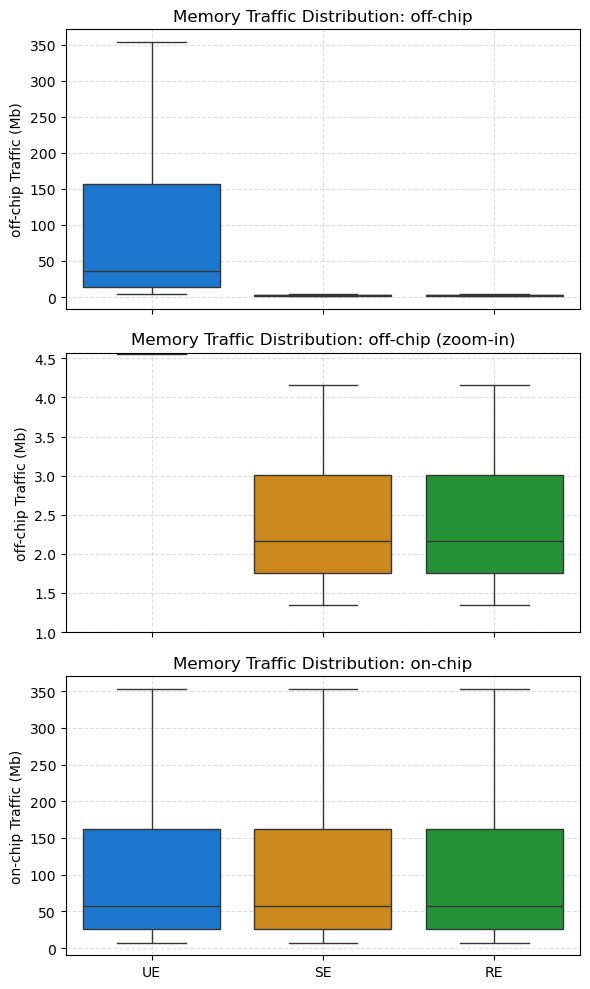

In [72]:
# Analyze memory traffic
traffic_result = analyze_original_mem_traffic(
    network_layers=network_layers,
    filter_size=filter_size,
    n_bit=n_bits
)

In [73]:
# Visualize numerical results
pprint(traffic_result)

[{'RE_off': 3.09100341796875,
  'RE_on': 57.99822998046875,
  'SE_off': 3.09100341796875,
  'SE_on': 57.99822998046875,
  'UE_off': 14.07244873046875,
  'UE_on': 57.99822998046875,
  'layer': 'stem'},
 {'RE_off': 4.1456298828125,
  'RE_on': 48.0714111328125,
  'SE_off': 4.1456298828125,
  'SE_on': 48.0714111328125,
  'UE_off': 26.1085205078125,
  'UE_on': 48.0714111328125,
  'layer': 'conv1'},
 {'RE_off': 2.1494140625,
  'RE_on': 24.2392578125,
  'SE_off': 2.1494140625,
  'SE_on': 24.2392578125,
  'UE_off': 13.1943359375,
  'UE_on': 24.2392578125,
  'layer': 'conv2'},
 {'RE_off': 1.3426513671875,
  'RE_on': 12.6864013671875,
  'SE_off': 1.3426513671875,
  'SE_on': 12.6864013671875,
  'UE_off': 7.0145263671875,
  'UE_on': 12.6864013671875,
  'layer': 'conv3'},
 {'RE_off': 1.6328125,
  'RE_on': 7.4765625,
  'SE_off': 1.6328125,
  'SE_on': 7.4765625,
  'UE_off': 4.5546875,
  'UE_on': 7.4765625,
  'layer': 'conv4'},
 {'RE_off': 2.556640625,
  'RE_on': 11.322265625,
  'SE_off': 2.556640625,

- Due to the significant off-chip traffic in UE architecture, **only SE and RE architectures** should be consider for the StereoSpike network.

### **1.2 Latency**
- To leverage the high temporal resolution in event cameras [3], low-latency processing is a crucial factor.  
- Following the framework presented in [1] and extending the formulas to any tensor dimension: input, output, filter, and stride.
    - Assumption 1: multiplication takes 1 cycle.
    - Assumption 2: ideal memory model (no memory access delay).

**UE Architecture:**
- Add latencies from DW and PW stages.
$$
t_{UE} = t_{DW} + t_{PW} \\
\qquad \qquad \qquad \qquad \qquad \qquad \qquad = \left\lceil \frac{RS}{i_{UE}} \right\rceil PQ \left\lceil \frac{C}{j_{UE}} \right\rceil + \left\lceil \frac{C}{i_{UE}} \right\rceil PQ \left\lceil \frac{M}{j_{UE}} \right\rceil
$$

**SE Architecture:**
- Consider only the stage that takes longer to process.
    - PW stage since output tensor volumen is always higher in a U-Net.
$$
t_{SE} = max(t_{DW},t_{PW}) \\
\qquad = \left\lceil \frac{C}{i^{P}_{SE}} \right\rceil PQ \left\lceil \frac{M}{j^{P}_{SE}} \right\rceil
$$

**RE Architecture:**  
- Two operation modes need to be considered:
$$
\text{operation}=
    \begin{cases}
        \text{inter-channel}, &  QC + CM \leq PQC + Cj_{RE} \\
        \text{intra-channel}, & \text{otherwise} 
    \end{cases}
$$

1. *Inter-channel*: for smaller input and fewer PW filters.
    - It generates 1 ofmap row with all its channels.
    - Two pipelines based on the number of output channels that can be computed concurrently: DW-PW or PW-DW.
$$
t_{RE}=
    \begin{cases}
        PQR \left\lceil \frac{C}{d} \right\rceil, &  M \leq j_{RE} - d \\
        \left\lceil \frac{C}{i_{RE}} \right\rceil PQ \left\lceil \frac{M}{j_{RE} - d} \right\rceil, & \text{otherwise} 
    \end{cases}
$$

2. *Intra-channel*: for larger input and many PW filters. 
    - It generates all the rows of several ofmap channels.
    - It has 2 stages:
        - Stage 1: All DW and some PW computations.
        - Stage 2: Remaining PW computations.
$$
\begin{split}
t_{RE} & = t_{s1} + t_{s2} \\
& = PQR \left\lceil \frac{C}{d} \right\rceil + PQ \left\lceil \frac{C}{i_{RE}} \right\rceil \left\lceil \frac{M - \left\lfloor \frac{R\left\lceil \frac{C}{d} \right\rceil}{\left\lceil \frac{C}{j_{RE} - d} \right\rceil} \right\rfloor}{j_{RE}} \right\rceil 
\end{split}
$$


#### **1.2.1 Analysis**
The number of rows and columns $(i,j)$ determines the latency with a fixed network.
- Assume accumulation in the vertical direction.
- Considering 3 cases based on the number of input/output channels: multiples of 32.
    - RE architecture is designed to handle varying number of input/output channels.

##### **1.2.1.1 Case 1**
- Input channels < Output channels.
- Resemble *encoder* conditions.

**UE:**
- For DW convolution: (49,64)
- For PW convolution: (64,128)
- Therefore, we use: *(49,128)*
    - DW convolution can handle 64 input channels with all the filter rows.
    - PW convolution can produce 128 output channels.

**SE:** 
- For DW convolution: (49,64)
- For PW convolution: (64,128)
    - DW convolution can handle 64 input channels with all the filter rows.
    - PW convolution can produce 128 output channels.

**RE:**
- For DW convolution: (7,64)
    - Its dataflow only considers the access to a single row with all their channels and perform an incomplete slididing window in several cycles. 
- For PW convolution: (64,128)  
- Therefore, we use: *(64,128)*
    - DW convolution can handle up to 128 input channels with a single filter row per cycle (idle PEs).
    - PW convolution can handle up to 64 input channels and produce 128 output channels.  
    
- *Inter-channel* --> small number of input/output channels
    - Choose a balance approach with 64 columns for each stage: handle 64 input channels and generate 64 output channels.
    - We use *d = 64*
    - In the case of prediction layers with only 1 output channel, we use optimize to *d = 127*  

- *Intra-channel* --> large number of input/output channels
    - Dynamic assignment of columns for both convolutions --> 2 stages.
    - During stage 1, most of the computations are focused on finishing DW convolutions
        - We use *d = 120*
    - Stage 2 automatically will take all 128 columns to complete PW convolutions. 

In [51]:
# (row, column) --> (i,j)

# UE
ue_array = (49, 128)

# SE
se_array_dw = (49, 64)
se_array_pw = (64, 128)

# RE
re_array = (64, 128)
dw_cols_inter = 64  # Number of columns for DW in RE for inter-channel
dw_cols_inter_prediction = 127  # Number of columns for DW in RE for inter-channel operation in prediction layers
dw_cols_intra = 120  # Number of columns for DW in RE for intra-channel

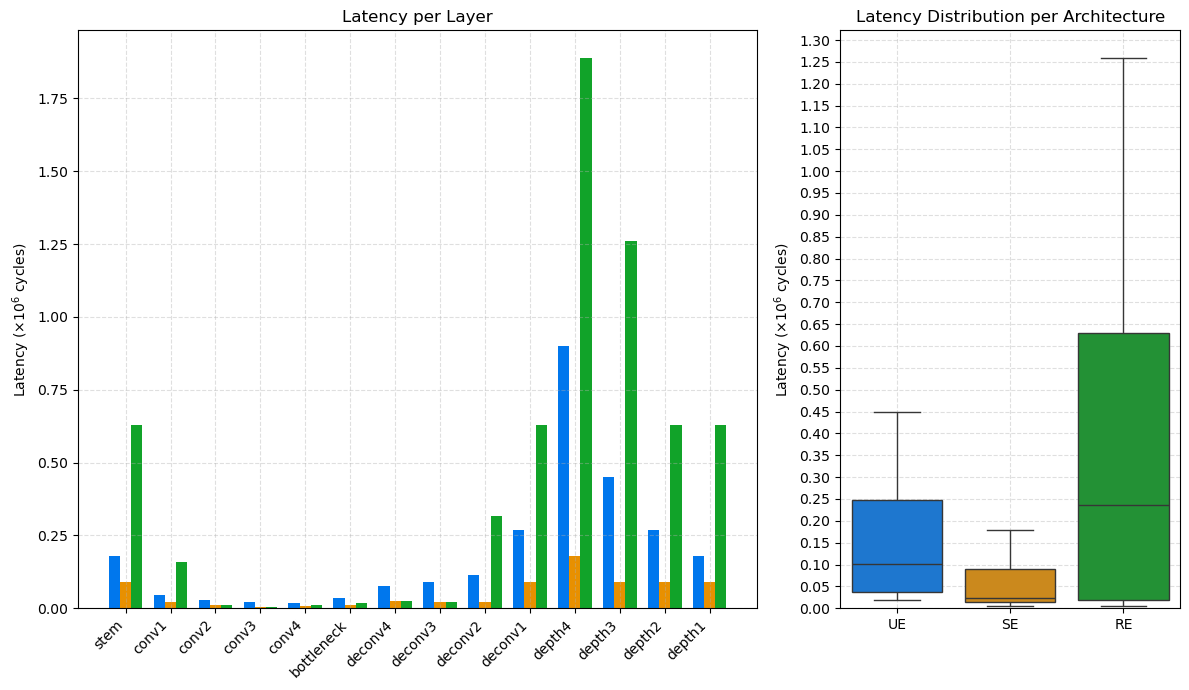

In [75]:
# Analyze latency
latency_results = analyze_original_latency(
    network_layers=network_layers,    
    filter_size=filter_size,
    compute_array_ue=ue_array,
    compute_array_se=se_array_pw,
    compute_array_re=re_array,
    dw_c_inter=dw_cols_inter,
    dw_c_inter_pred=dw_cols_inter_prediction,
    dw_c_intra=dw_cols_intra,
    verbose=False
)

In [27]:
# Visualize numerical results
pprint(latency_results)

[{'RE_latency': 629720,
  'SE_latency': 89960,
  'UE_latency': 179920,
  'layer': 'stem'},
 {'RE_latency': 157430,
  'SE_latency': 22490,
  'UE_latency': 44980,
  'layer': 'conv1'},
 {'RE_latency': 11310,
  'SE_latency': 5655,
  'UE_latency': 16965,
  'layer': 'conv2'},
 {'RE_latency': 11616,
  'SE_latency': 5808,
  'UE_latency': 10164,
  'layer': 'conv3'},
 {'RE_latency': 13838,
  'SE_latency': 5984,
  'UE_latency': 9724,
  'layer': 'conv4'},
 {'RE_latency': 25058,
  'SE_latency': 11968,
  'UE_latency': 17952,
  'layer': 'bottleneck'},
 {'RE_latency': 46464,
  'SE_latency': 23232,
  'UE_latency': 37752,
  'layer': 'deconv4'},
 {'RE_latency': 45240,
  'SE_latency': 22620,
  'UE_latency': 45240,
  'layer': 'deconv3'},
 {'RE_latency': 314860,
  'SE_latency': 44980,
  'UE_latency': 89960,
  'layer': 'deconv2'},
 {'RE_latency': 629720,
  'SE_latency': 89960,
  'UE_latency': 269880,
  'layer': 'deconv1'},
 {'RE_latency': 1889160,
  'SE_latency': 359840,
  'UE_latency': 719680,
  'layer': 'd

##### **1.2.1.2 Case 2**
- Input channels = Output channels.
- Resemble *bottleneck* conditions.

**UE:**
- For DW convolution: (49,128)
- For PW convolution: (128,128)
- Therefore, we use: *(49,128)*
    - DW convolution can handle 128 input channels with all the filter rows.
    - PW convolution can produce 128 output channels.

**SE:** 
- For DW convolution: (49,128)
- For PW convolution: (128,128)
    - DW convolution can handle 128 input channels with all the filter rows.
    - PW convolution can produce 128 output channels.

**RE:**
- For DW convolution: (7,128)
    - Its dataflow only considers the access to a single row with all their channels and perform an incomplete slididing window in several cycles. 
- For PW convolution: (128,128)  
- Therefore, we use: *(128,128)*
    - DW convolution can handle up to 128 input channels with a single filter row per cycle (idle PEs).
    - PW convolution can handle up to 128 input channels and produce 128 output channels.  
    
- *Inter-channel* --> small number of input/output channels
    - Choose a balance approach with 64 columns for each stage: handle 64 input channels and generate 64 output channels.
    - We use *d = 64*
    - In the case of prediction layers with only 1 output channel, we use optimize to *d = 127*  

- *Intra-channel* --> large number of input/output channels
    - Dynamic assignment of columns for both convolutions --> 2 stages.
    - During stage 1, most of the computations are focused on finishing DW convolutions
        - We use *d = 120*
    - Stage 2 automatically will take all 128 columns to complete PW convolutions. 

In [64]:
# (row, column) --> (i,j)

# UE
ue_array = (49, 128)

# SE
# (row, column) --> (i,j)
se_array_dw = (49, 128)
se_array_pw = (128, 128)

# RE
# (row, column) --> (i,j)
re_array = (128, 128)
dw_cols_inter = 64  # Number of columns for DW in RE for inter-channel
dw_cols_inter_prediction = 127  # Number of columns for DW in RE for inter-channel operation in prediction layers
dw_cols_intra = 120  # Number of columns for DW in RE for intra-channel

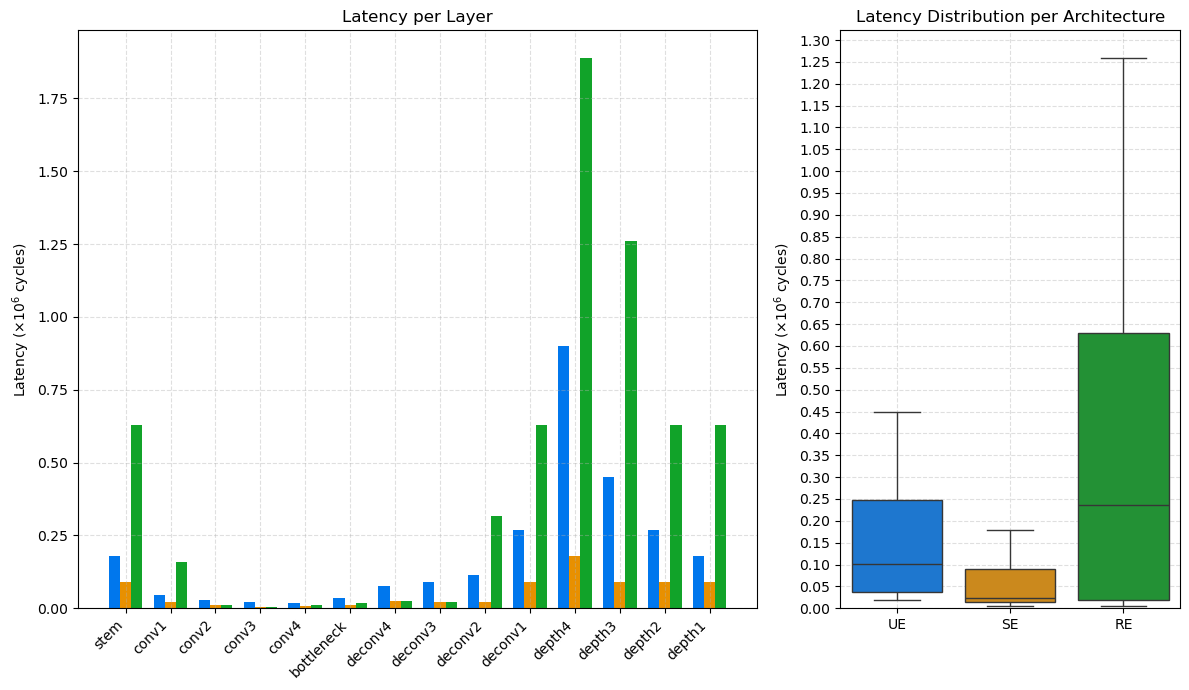

In [76]:
# Analyze latency
latency_results = analyze_original_latency(
    network_layers=network_layers,    
    filter_size=filter_size,
    compute_array_ue=ue_array,
    compute_array_se=se_array_pw,
    compute_array_re=re_array,
    dw_c_inter=dw_cols_inter,
    dw_c_inter_pred=dw_cols_inter_prediction,
    dw_c_intra=dw_cols_intra,
    verbose=False
)

In [96]:
# Visualize numerical results
pprint(latency_results)

[{'RE_latency': 629720,
  'SE_latency': 89960,
  'UE_latency': 179920,
  'layer': 'stem'},
 {'RE_latency': 157430,
  'SE_latency': 22490,
  'UE_latency': 44980,
  'layer': 'conv1'},
 {'RE_latency': 11310,
  'SE_latency': 5655,
  'UE_latency': 16965,
  'layer': 'conv2'},
 {'RE_latency': 5808,
  'SE_latency': 2904,
  'UE_latency': 10164,
  'layer': 'conv3'},
 {'RE_latency': 10846,
  'SE_latency': 2992,
  'UE_latency': 9724,
  'layer': 'conv4'},
 {'RE_latency': 19074,
  'SE_latency': 5984,
  'UE_latency': 17952,
  'layer': 'bottleneck'},
 {'RE_latency': 23232,
  'SE_latency': 11616,
  'UE_latency': 37752,
  'layer': 'deconv4'},
 {'RE_latency': 22620,
  'SE_latency': 11310,
  'UE_latency': 45240,
  'layer': 'deconv3'},
 {'RE_latency': 314860,
  'SE_latency': 22490,
  'UE_latency': 89960,
  'layer': 'deconv2'},
 {'RE_latency': 629720,
  'SE_latency': 89960,
  'UE_latency': 269880,
  'layer': 'deconv1'},
 {'RE_latency': 1889160,
  'SE_latency': 179920,
  'UE_latency': 719680,
  'layer': 'dep

##### **1.2.1.3 Case 3**
- Input channels > Output channels.
- Resemble *decoder* conditions.

**UE:**
- For DW convolution: (49,128)
- For PW convolution: (128,64)
- Therefore, we use: *(49,64)*
    - DW convolution can handle 128 input channels with all the filter rows.
    - PW convolution can produce 64 output channels.

**SE:** 
- For DW convolution: (49,128)
- For PW convolution: (128,64)
    - DW convolution can handle 128 input channels with all the filter rows.
    - PW convolution can produce 64 output channels.

**RE:**
- For DW convolution: (7,128)
    - Its dataflow only considers the access to a single row with all their channels and perform an incomplete slididing window in several cycles. 
- For PW convolution: (128,64)  
- Therefore, we use: *(128,128)*
    - DW convolution can handle up to 128 input channels with a single filter row per cycle (idle PEs).
    - PW convolution can handle up to 128 input channels and produce 128 output channels.  
    
- *Inter-channel* --> small number of input/output channels
    - Choose a balance approach with 64 columns for each stage: handle 64 input channels and generate 64 output channels.
    - We use *d = 64*
    - In the case of prediction layers with only 1 output channel, we use optimize to *d = 127*  

- *Intra-channel* --> large number of input/output channels
    - Dynamic assignment of columns for both convolutions --> 2 stages.
    - During stage 1, most of the computations are focused on finishing DW convolutions
        - We use *d = 120*
    - Stage 2 automatically will take all 128 columns to complete PW convolutions. 

In [66]:
# (row, column) --> (i,j)

# UE
ue_array = (49, 64)

# SE
# (row, column) --> (i,j)
se_array_dw = (49, 128)
se_array_pw = (128, 64)

# RE
# (row, column) --> (i,j)
re_array = (128, 128)
dw_cols_inter = 64  # Number of columns for DW in RE for inter-channel
dw_cols_inter_prediction = 127  # Number of columns for DW in RE for inter-channel operation in prediction layers
dw_cols_intra = 120  # Number of columns for DW in RE for intra-channel

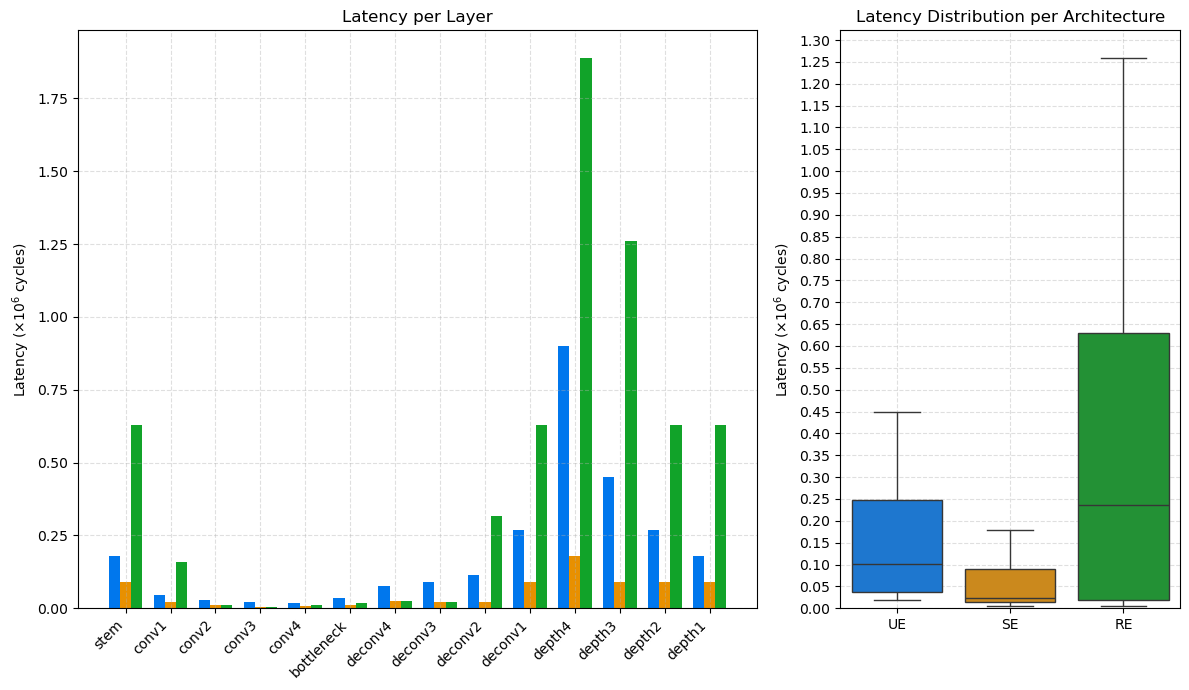

In [77]:
# Analyze latency
latency_results = analyze_original_latency(
    network_layers=network_layers,    
    filter_size=filter_size,
    compute_array_ue=ue_array,
    compute_array_se=se_array_pw,
    compute_array_re=re_array,
    dw_c_inter=dw_cols_inter,
    dw_c_inter_pred=dw_cols_inter_prediction,
    dw_c_intra=dw_cols_intra,
    verbose=False
)

In [ ]:
# Visualize numerical results
pprint(latency_results)

[{'RE_latency': 629720,
  'SE_latency': 89960,
  'UE_latency': 179920,
  'layer': 'stem'},
 {'RE_latency': 157430,
  'SE_latency': 22490,
  'UE_latency': 44980,
  'layer': 'conv1'},
 {'RE_latency': 11310,
  'SE_latency': 5655,
  'UE_latency': 16965,
  'layer': 'conv2'},
 {'RE_latency': 5808,
  'SE_latency': 2904,
  'UE_latency': 10164,
  'layer': 'conv3'},
 {'RE_latency': 10846,
  'SE_latency': 2992,
  'UE_latency': 9724,
  'layer': 'conv4'},
 {'RE_latency': 19074,
  'SE_latency': 5984,
  'UE_latency': 17952,
  'layer': 'bottleneck'},
 {'RE_latency': 23232,
  'SE_latency': 11616,
  'UE_latency': 37752,
  'layer': 'deconv4'},
 {'RE_latency': 22620,
  'SE_latency': 11310,
  'UE_latency': 45240,
  'layer': 'deconv3'},
 {'RE_latency': 314860,
  'SE_latency': 22490,
  'UE_latency': 89960,
  'layer': 'deconv2'},
 {'RE_latency': 629720,
  'SE_latency': 89960,
  'UE_latency': 269880,
  'layer': 'deconv1'},
 {'RE_latency': 1889160,
  'SE_latency': 179920,
  'UE_latency': 719680,
  'layer': 'dep

- **SE architeture** shows a reduced and more consist latency among layers. 
- In the case of RE, we can see that its large variability is due to its dataflow, which depends on the input resolution.
    - Dataflow processes a single ifmap row.

## **2. Proposed Architecture**
- Based on the previous analysis, the best candidate to implement StereoSpike network is the **SE architecture**. 
    - We proposed a variation that eliminates the storage of intermediate data (pfmaps) to reduce on-chip traffic.
    - Also off-chip traffic is reduced by reading only the initial event frames and compute consecutive layers with the on-chip data.

![proposed architecture](./images/proposed_arch.png)

### **2.1 Memory Traffic**
- Following the previous framework, equations for the proposed architecture are presented.

The size of the individual tensors are:  
- $\textcircled{1}$ Event frames --> $HWC$ (binary data)
- $\textcircled{2}$ ifmap (DW) --> $HWC$ (binary data)
- $\textcircled{3}$ ofmap (PW) --> $PQM$ (binary/multibit data)
- $\textcircled{4}$ pfmap (DW->PW) --> $PQC$ (multibit data)
- $\textcircled{5}$ weights --> $RSC + MC$ (multibit data)
- $\textcircled{6}$ Depth map --> $PQ$ (multibit data) 

**Off-chip:**  
- $\textcircled{1}$ is binary.  
- $\textcircled{5}$ and $\textcircled{6}$ are multibit.
$$
    A^{off} = \underset{\text{read}}{\underbrace{\textcircled{1}+\textcircled{5}}} + \underset{\text{write}}{\underbrace{\textcircled{6}}}
$$

**On-chip:**
- Following the previous ideal estimations, we also consider just 1 binary ofmap write and 1 multibit ofmap read.
    - $\textcircled{2}$ and $\textcircled{3}$ (write) are binary.  
    - $\textcircled{3}$ (read) and $\textcircled{5}$ are multibit.
$$
    A^{on} = \underset{\text{read}}{\underbrace{\textcircled{2}+\textcircled{3}+\textcircled{5}}} + \underset{\text{write}}{\underbrace{\textcircled{3}}}
$$

#### **2.1.1 Analysis**
The bitwidth of each tensor element determines the memory traffic with a fixed network.
- Assume 8-bit quantization for weights.

In [80]:
# Bitwidths for weights, pfmap, and ofmap
n_bits = (8, 16, 16)

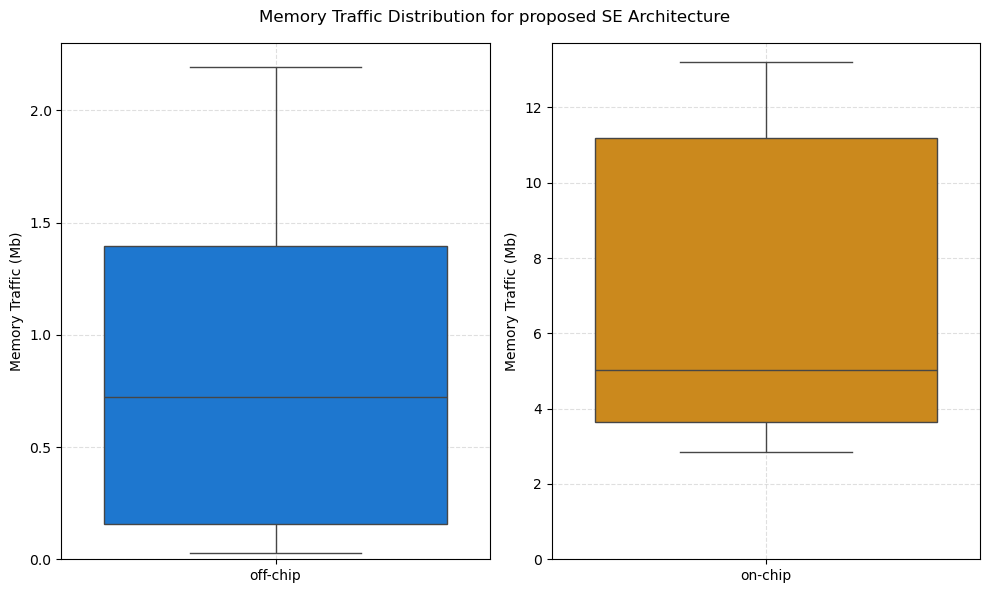

In [96]:
# Analyze memory traffic
prop_traffic_results = analyze_prop_mem_traffic(
    network_layers=network_layers,
    filter_size=filter_size,
    n_bit=n_bits
)

In [97]:
pprint(prop_traffic_results)

[{'layer': 'stem',
  'off_1': 0.343170166015625,
  'off_5': 0.002471923828125,
  'off_6': 0.0,
  'off_total': 0.34564208984375,
  'on_2': 0.343170166015625,
  'on_3': 2.745361328125,
  'on_5': 0.002471923828125,
  'on_total': 3.09100341796875},
 {'layer': 'conv1',
  'off_1': 0.0,
  'off_5': 0.027587890625,
  'off_6': 0.0,
  'off_total': 0.027587890625,
  'on_2': 2.745361328125,
  'on_3': 1.3726806640625,
  'on_5': 0.027587890625,
  'on_total': 4.1456298828125},
 {'layer': 'conv2',
  'off_1': 0.0,
  'off_5': 0.08642578125,
  'off_6': 0.0,
  'off_total': 0.08642578125,
  'on_2': 1.3726806640625,
  'on_3': 11.7352294921875,
  'on_5': 0.08642578125,
  'on_total': 13.1943359375},
 {'layer': 'conv3',
  'off_1': 0.0,
  'off_5': 0.2978515625,
  'off_6': 0.0,
  'off_total': 0.2978515625,
  'on_2': 0.6903076171875,
  'on_3': 6.0263671875,
  'on_5': 0.2978515625,
  'on_total': 7.0145263671875},
 {'layer': 'conv4',
  'off_1': 0.0,
  'off_5': 1.095703125,
  'off_6': 0.0,
  'off_total': 1.095703125,

### **2.2 Latency**
- The proposed modification of SE architecture follows the previous formulas for latency estimation.

#### **2.2.1 Analysis**
The number of rows and columns $(i,j)$ determines the latency with a fixed network.
- Due to the direct feed from DW array to PW array, the dimensions of PW array defined both arrays.
    - Consider the max. number of input/output channels as the limits for the seach: 512.

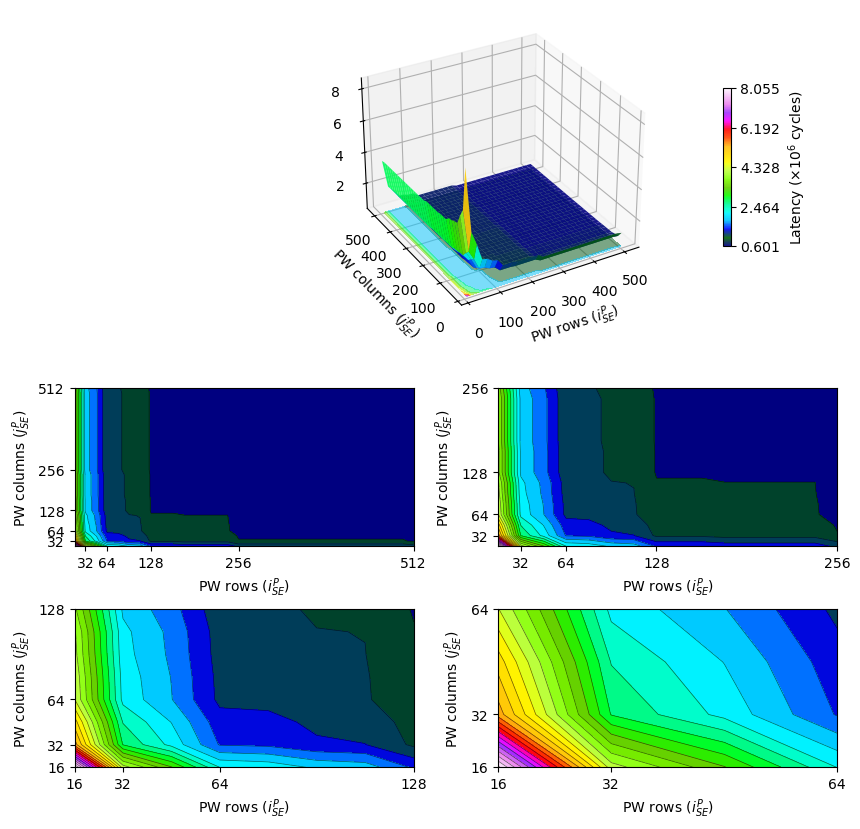

In [204]:
latency_grid_m, i_vals, j_vals = plot_total_se_latency_surface(
    network_layers=network_layers,
    se_array_pw_range_i=(16, 512),
    se_array_pw_range_j=(16, 512),
    step_i=16,
    step_j=16,
    cmap='gist_ncar'
)

# **References**
[1] B. Li et al., “Dynamic Dataflow Scheduling and Computation Mapping Techniques for Efficient Depthwise Separable Convolution Acceleration,” IEEE Trans. Circuits Syst. I: Reg. Papers, vol. 68, no. 8, pp. 3279–3292, Aug. 2021. https://doi.org/10.1109/TCSI.2021.3078541.  
[2] V. Sze, Y.-H. Chen, T.-J. Yang, and J. S. Emer, Efficient Processing of Deep Neural Networks, 1st ed., Synthesis Lectures on Computer Architecture. Springer Cham, 2020. https://doi.org/10.1007/978-3-031-01766-7.  
[3] G. Gallego et al., “Event-Based Vision: A Survey,” IEEE Trans. Pattern Anal. Mach. Intell., vol. 44, no. 1, pp. 154–180, Jan. 2022, doi:10.1109/TPAMI.2020.3008413.